<a href="https://colab.research.google.com/github/kato-taki/optimization-of-cultured-meat/blob/main/0822%E6%9C%80%E5%B0%8F%E4%BA%8C%E4%B9%97%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input

## Import library


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit

## Parameter value and Constant value


In [ ]:
##1.1 モデルパラメータの初期値およびin vitro実験データから直接推定できるモデルパラメータの推定値
#動物細胞培養(C2C12マウス筋芽細胞)
#播種密度
#1サイクル目
X0_cell_1st = 79126666 #cells/L, in vitro実験データを使用．
#2サイクル目
X0_cell_2nd = 97090583 #cells/L, in vitro実験データを使用．
#最大比増殖速度
umax_cell = 0.02074 #h-1, in vitro実験データから直接推定．
#培地成分（グルコース，乳酸，グルタミン，アンモニア）濃度
Cglc0_cell = 22.75805413 #mmol/L, in vitro実験データを使用．
Clac0_cell = 4.688425104 #mmol/L, in vitro実験データを使用．
Cgln0_cell = 1.789033333 #mmol/L, in vitro実験データを使用．
Camm0_cell = 1.244788914 #mmol/L, in vitro実験データを使用．
#増殖した細胞密度に対して代謝された培地成分（グルコース，乳酸，グルタミン，アンモニア）濃度の割合
qglc_cell = 5.19922e-8   # ΔCglc/ΔX (mmol/cells), in vitro実験データから直接推定．
qlac_cell = 9.08415e-8   # ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．
qgln_cell = 3.95034e-9  # ΔCgln/ΔX (mmol/cells), in vitro実験データから直接推定．
qamm_cell = 2.56415e-10 # ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．


#藻類培養(乳酸資化シネココッカス)
#播種密度
#1サイクル目
X0_algae_1st = 44476333333  #cells/L, in vitro実験データを使用．
#2サイクル目
X0_algae_2nd = 58910000000  #cells/L, in vitro実験データを使用．
#最大比増殖速度
umax_algae = 0.00265  #h-1, in vitro実験データから直接推定．
#増殖した細胞密度に対して代謝された培地成分（乳酸，グルタミン，アンモニア）濃度の割合
qlac_algae = 9.08281e-10    # ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．
qgln_algae = 1.10727e-12  # ΔCgln/ΔX (mmol/cells), in vitro実験データから直接推定．
qamm_algae = 8.2387e-11    # ΔClac/ΔX (mmol/cells), in vitro実験データから直接推定．


#藻類酸加水分解による栄養素抽出
#グルコース抽出定数
kglc = 0.00000000105492  #mmol/cells,in vitro実験データから直接推定．

In [ ]:
##1.2 in vitro実験データから直接推定できないモデルパラメータの初期推定値
#飽和定数KS
#動物細胞
Kglc = 0.75   #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．
Kgln = 0.075  #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．
#藻類
Kamm_algae = 0.0135 #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．
#阻害定数KI
Klac_cell = 172   #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．
Kamm_cell = 28.48 #mmol/L, 文献データから引用．最小二乗法を使用してフィッティング．

#乳酸取り込み定数
uptake_max = 0.0000000156 #mmol/L, 文献データから引用し，推定値とする．
Klac_uptake = 1.31 #mmol/L, 文献データから引用し，推定値とする．
#グルタミン分解定数，
kd_gln = 0.000096 #h-1, 文献データから引用し，推定値とする．

In [ ]:
##1.3 実験条件
#動物細胞培養
T_cell = 68           #h,1サイクルの培養時間
n_cell = 68*60        #1サイクルの計算回数
h = T_cell / n_cell   #h,タイムステップ
t_cell = np.arange(0,T_cell,h)

#藻類培養
T_algae = 96          #h,1サイクルの培養時間
n_algae = 96*60       #1サイクルの計算回数
h = T_algae / n_algae #h,タイムステップ
t_algae = np.arange(0,T_algae,h)

#サイクル数
cycle_num = 2

#藻類から抽出したグルコースを添加した割合
k_hydrolysis = 5/100

## Lists

In [ ]:
##2. CCCモデルパラメータの経時変化を格納するリスト．
list_X_cell     = [] #動物細胞密度
list_X_algae    = [] #藻類細胞密度
list_u_cell     = [] #動物細胞比増殖速度
list_u_algae    = [] #藻類比増殖速度
list_Cglc       = [] #グルコース濃度
list_Clac       = [] #乳酸濃度
list_Cgln       = [] #グルタミン濃度
list_Camm       = [] #アンモニア
list_time       = [] #培養時間
list_time_cell  = [] #動物細胞培養時間
list_time_algae = [] #藻類培養時間

## Definition of culture process function

In [ ]:
##3.1 動物細胞培養のクラス
class animal_cell_culture:
	#比増殖速度
	def u(self,Cglc,Clac,Cgln,Camm):
		return umax_cell *(Cglc/(Kglc+Cglc*(1+Clac/Klac_cell)))*(Cgln/(Kgln+Cgln*(1+Camm/Kamm_cell)))
	#増殖速度式
	def cell_growth(self,u):
		f = lambda X_cell,t=0 : u*X_cell
		return f
	#グルコース代謝
	def glucose(self,X0,u,t,Cglc0):
		return -qglc_cell*X0*math.exp(u*t)+(Cglc0+qglc_cell*X0)
	#乳酸代謝
	def lactate(self,X0,u,t,Clac0):
		return qlac_cell*X0*math.exp(u*t)+(Clac0-qlac_cell*X0)
	#グルタミン代謝
	def glutamine_met(self,X0,u,t,Cgln0):
		return -qgln_cell*X0*math.exp(u*t)+(Cgln0+qgln_cell*X0)
	#グルタミン分解
	def glutamine_deg(self):
		f = lambda Cgln,t=0 : -kd_gln*Cgln
		return f
	#アンモニア代謝
	def ammonia(self,X0,u,t,Camm0):
		return qamm_cell*X0*math.exp(u*t)+(Camm0-qamm_cell*X0)


##3.2 藻類培養のクラス
class algae_culture:
	def u(self,Camm):
		return umax_algae *(Camm/(Kamm_algae+Camm))
	#増殖速度式
	def cell_growth(self,u):
		f = lambda X_cell,t=0 : u*X_cell
		return f
	#乳酸代謝
	def lactate(self,X0,u,t,Clac0):
		return -qlac_algae*X0*math.exp(u*t)+(Clac0+qlac_algae*X0)
	#グルタミン代謝
	def glutamine_met(self,X0,u,t,Cgln0):
		return qgln_algae*X0*math.exp(u*t)+(Cgln0-qgln_algae*X0)
	#グルタミン分解
	def glutamine_deg(self):
		f = lambda Cgln,t=0 : -kd_gln*Cgln
		return f
	#アンモニア代謝
	def ammonia(self,X0,u,t,Camm0):
		return -qamm_algae*X0*math.exp(u*t)+(Camm0+qamm_algae*X0)

# Process

## Definition of CCC model

In [ ]:
##4. CCCモデルの定義
def CCC_model():
  #=============================================================================
  #CCCモデルパラメータの初期値
  #=============================================================================
  #培養時間
  time = 0
  #培地濃度
  Cglc   =  Cglc0_cell
  Clac   =  Clac0_cell
  Cgln   =  Cgln0_cell
  Camm   =  Camm0_cell

  #=============================================================================
  #CCCモデルの実行
  #=============================================================================
  for i in range(cycle_num):
    #===========================================================================
    #動物細胞培養プロセスの初期設定
    #===========================================================================
    #1. 動物細胞培養モジュールの呼び出し
    #クラスから動物細胞培養モジュールを呼び出す．
    process1 = animal_cell_culture()
    #モジュール内の比増殖速度を呼び出す．
    u = process1.u(Cglc,Clac,Cgln,Camm)
    #2. 動物細胞培養の経時変化を格納するリストの定義および初期値の格納．
    #2.1 比増殖速度
    list_u_cell_t = np.empty(n_cell)
    list_u_cell_t[0] = u
    #2.2 培地濃度
    #2.2.1 グルコース
    list_Cglc_cell_t = np.empty(n_cell)
    list_Cglc_cell_t[0] = Cglc
    #2.2.2 乳酸
    list_Clac_cell_t = np.empty(n_cell)
    list_Clac_cell_t[0] = Clac
    #2.2.3 グルタミン
    list_Cgln_cell_t = np.empty(n_cell)
    list_Cgln_cell_t[0] = Cgln
    #2.2.4 アンモニア
    list_Camm_cell_t = np.empty(n_cell)
    list_Camm_cell_t[0] = Camm
    #2.2.5 培養時間
    list_time_cell_t = np.empty(n_cell)
    list_time_cell_t[0] = time
    #2.2.6 1サイクル目の初期細胞密度と培地濃度の初期値の定義．
    if i == 0:
      #初期細胞密度
      X0 = X0_cell_1st
      list_X_cell_t = np.empty(n_cell)
      list_X_cell_t[0] = X0
      #培地濃度の初期値
      Cglc0   =  list_Cglc_cell_t[0]
      Clac0   =  list_Clac_cell_t[0]
      Cgln0   =  list_Cgln_cell_t[0]
      Camm0   =  list_Camm_cell_t[0]
    #2.2.7 2サイクル目の初期細胞密度の定義．
    else:
      #初期細胞密度
      X0 = X0_cell_2nd
      list_X_cell_t = np.empty(n_cell)
      list_X_cell_t[0] = X0


    #===========================================================================
    #3. 動物細胞培養プロセスの実行
    #===========================================================================
    for t in range(n_cell-1):
      #3.1 増殖反応
      #モジュール内の増殖反応を呼び出す．
      f = process1.cell_growth(u)
      #ルンゲクッタ法による計算
      k_1 = h * f(list_X_cell_t[t],t_cell[t])
      k_2 = h * f(list_X_cell_t[t] + k_1 /2 , t_cell[t] + h/2 )
      k_3 = h * f(list_X_cell_t[t] + k_2 /2 , t_cell[t] + h/2 )
      k_4 = h * f(list_X_cell_t[t] + k_3 , t_cell[t] + h )
      list_X_cell_t[t+1] = list_X_cell_t[t] + 1/6 * (k_1 + 2*k_2 + 2*k_3 + k_4 )
      #3.2 代謝反応
      #モジュール内の代謝反応を呼び出す．
      #3.2.1 グルコース代謝
      Cglc = process1.glucose(X0,u,t/60,Cglc0)
      list_Cglc_cell_t[t+1] = Cglc
      #3.2.2 乳酸代謝
      Clac = process1.lactate(X0,u,t/60,Clac0)
      list_Clac_cell_t[t+1] = Clac
      #3.2.3 グルタミン代謝
      Cgln = process1.glutamine_met(X0,u,t/60,Cgln0)
      #モジュール内のグルタミン分解反応を呼び出す．
      gln = process1.glutamine_deg()
      #ルンゲクッタ法による計算
      h_1 = h * gln(list_Cgln_cell_t[t],t_cell[t])
      h_2 = h * gln(list_Cgln_cell_t[t] + h_1 /2 , t_cell[t] + h/2 )
      h_3 = h * gln(list_Cgln_cell_t[t] + h_2 /2 , t_cell[t] + h/2 )
      h_4 = h * gln(list_Cgln_cell_t[t] + h_3 , t_cell[t] + h )
      list_Cgln_cell_t[t+1] = Cgln - 1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)  #1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)は分解されたグルタミン濃度
      Cgln = list_Cgln_cell_t[t+1]
      #3.2.4 アンモニア代謝
      Camm = process1.ammonia(X0,u,t/60,Camm0)
      list_Camm_cell_t[t+1] = Camm + 1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)  #1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)は分解されたグルタミン濃度
      Camm = list_Camm_cell_t[t+1]
      #3.3 比増殖速度
      list_u_cell_t[t+1] = u
      #3.4 培養時間
      time += h
      list_time_cell_t[t+1] = time

    #3.5 リストに動物細胞培養の経時変化を格納する
    list_X_cell.extend(list_X_cell_t)
    list_u_cell.extend(list_u_cell_t)
    list_Cglc.extend(list_Cglc_cell_t)
    list_Clac.extend(list_Clac_cell_t)
    list_Cgln.extend(list_Cgln_cell_t)
    list_Camm.extend(list_Camm_cell_t)
    list_time.extend(list_time_cell_t)
    list_time_cell.extend(list_time_cell_t)


    #===========================================================================
    #培地交換プロセス
    #===========================================================================
    #3.6 動物細胞培地濃度を藻類培地濃度の初期値として定義する．
    Cglc0   =  list_Cglc_cell_t[-1]
    Clac0   =  list_Clac_cell_t[-1]
    Cgln0   =  list_Cgln_cell_t[-1]
    Camm0   =  list_Camm_cell_t[-1]


    #===========================================================================
    #藻類培養プロセスの初期設定
    #===========================================================================
    #4. 藻類培養モジュールの呼び出し
    #クラスから藻類培養モジュールを呼び出す．
    process2 = algae_culture()
    #モジュール内の比増殖速度を呼び出す．
    u = process2.u(Camm)
    #5. 藻類培養の経時変化を格納するリスト
    #5.1 比増殖速度
    list_u_algae_t = np.empty(n_algae)
    list_u_algae_t[0] = u
    #5.2 培地濃度
    #5.2.1 グルコース
    list_Cglc_algae_t = np.empty(n_algae)
    list_Cglc_algae_t[0] = Cglc
    #5.2.2 乳酸
    list_Clac_algae_t = np.empty(n_algae)
    list_Clac_algae_t[0] = Clac
    #5.2.3 グルタミン
    list_Cgln_algae_t = np.empty(n_algae)
    list_Cgln_algae_t[0] = Cgln
    #5.2.4 アンモニア
    list_Camm_algae_t = np.empty(n_algae)
    list_Camm_algae_t[0] = Camm
    #5.2.5 培養時間
    list_time_algae_t = np.empty(n_algae)
    list_time_algae_t[0] = time
    #5.2.6 1サイクル目の初期細胞密度の定義．
    if i == 0:
      X0 = X0_algae_1st
      list_X_algae_t = np.empty(n_algae)
      list_X_algae_t[0] = X0
    #5.2.7 2サイクル目の初期細胞密度の定義．
    else:
      X0 = X0_algae_2nd
      list_X_algae_t = np.empty(n_algae)
      list_X_algae_t[0] = X0

    #===========================================================================
    #6. 藻類培養プロセスの実行
    #===========================================================================
    for t in range(0,n_algae-1):
      #6.1 増殖反応
      #モジュール内の増殖反応を呼び出す．
      f = process2.cell_growth(u)
      #ルンゲクッタ法による計算
      k_1 = h * f(list_X_algae_t[t],t_algae[t])
      k_2 = h * f(list_X_algae_t[t] + k_1 /2 , t_algae[t] + h/2 )
      k_3 = h * f(list_X_algae_t[t] + k_2 /2 , t_algae[t] + h/2 )
      k_4 = h * f(list_X_algae_t[t] + k_3 , t_algae[t] + h )
      list_X_algae_t[t+1] = list_X_algae_t[t] + 1/6 * (k_1 + 2*k_2 + 2*k_3 + k_4 )
      #6.2 代謝反応
      #モジュール内の代謝反応を呼び出す．
      #6.2.1 乳酸代謝
      Clac = process2.lactate(X0,u,t/60,Clac0)
      list_Clac_algae_t[t+1] = Clac
      #6.2.2 グルタミン代謝
      Cgln = process2.glutamine_met(X0,u,t/60,Cgln0)
      #モジュール内のグルタミン分解反応を呼び出す．
      gln = process2.glutamine_deg()
      #ルンゲクッタ法による計算
      h_1 = h * gln(list_Cgln_algae_t[t],t_algae[t])
      h_2 = h * gln(list_Cgln_algae_t[t] + h_1 /2 , t_algae[t] + h/2 )
      h_3 = h * gln(list_Cgln_algae_t[t] + h_2 /2 , t_algae[t] + h/2 )
      h_4 = h * gln(list_Cgln_algae_t[t] + h_3 , t_algae[t] + h )
      list_Cgln_algae_t[t+1] = Cgln - 1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)  #1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)は分解されたグルタミン濃度
      Cgln = list_Cgln_algae_t[t+1]
      #6.2.3 アンモニア代謝
      Camm = process2.ammonia(X0,u,t/60,Camm0)
      list_Camm_algae_t[t+1] = Camm + 1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)  #1/6 * (h_1 + 2*h_2 + 2*h_3 + h_4)は分解されたグルタミン濃度
      Camm = list_Camm_algae_t[t+1]
      #6.3 比増殖速度
      list_u_algae_t[t+1] = u
      #6.4 培養時間
      time += h
      list_time_algae_t[t+1] = time

    #6.5 リストに藻類培養の経時変化を格納する
    list_X_algae.extend(list_X_algae_t)
    list_u_algae.extend(list_u_algae_t)
    list_Cglc.extend(list_Cglc_algae_t)
    list_Clac.extend(list_Clac_algae_t)
    list_Cgln.extend(list_Cgln_algae_t)
    list_Camm.extend(list_Camm_algae_t)
    list_time.extend(list_time_algae_t)
    list_time_algae.extend(list_time_algae_t)


    #===========================================================================
    #7. 藻類栄養素抽出プロセス
    #===========================================================================
    #7.1 酸加水分解反応
    list_Cglc_algae_t[-1] = Cglc + k_hydrolysis*kglc*list_X_algae_t[-1]
    list_Clac_algae_t[-1] = Clac*(1 - k_hydrolysis)
    list_Cgln_algae_t[-1] = Cgln*(1 - k_hydrolysis)
    list_Camm_algae_t[-1] = Camm*(1 - k_hydrolysis)


    #===========================================================================
    #培地交換プロセス
    #===========================================================================
    #8. 藻類培地濃度を動物細胞培地濃度の初期値として定義する．
    Cglc0   =  list_Cglc_algae_t[-1]
    Clac0   =  list_Clac_algae_t[-1]
    Cgln0   =  list_Cgln_algae_t[-1]
    Camm0   =  list_Camm_algae_t[-1]


  return list_time,list_time_cell,list_time_algae,list_X_cell,list_X_algae,list_u_cell,list_u_algae,list_Cglc,list_Clac,list_Cgln,list_Camm

# Output

## Least-squares method

In [ ]:
list_time,list_time_cell,list_time_algae,list_X_cell,list_X_algae,list_u_cell,list_u_algae,list_Cglc,list_Clac,list_Cgln,list_Camm = CCC_model(

0.0026226291044785764
14.675596581097025
0.1690267199231525
-1.0468013374697844


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
def model_wrapper(Kglc, Kgln):
    # tは164時間から232時間の時間リスト
    _, predicted_X = CCC_model(Kglc, Kgln)
    # `predicted_X`が関数から返される細胞密度のリスト
    return predicted_X
# 実験データの定義
t_exp = np.array([164, 232])  # 培養時間のリスト
X_exp = np.array([9.71e7, 2.58e8])  # 実験データの細胞密度

# フィッティングを実行
initial_guess = [0.75, 0.075]  # Kglc, Kgln の初期推定値
params, covariance = curve_fit(model_wrapper, t_exp, X_exp, p0=initial_guess)

# フィッティング後のパラメータ
Kglc_fitted, Kgln_fitted = params

print(f"Fitted Kglc: {Kglc_fitted}")
print(f"Fitted Kgln: {Kgln_fitted}")


TypeError: model_wrapper() takes 2 positional arguments but 3 were given

## Time profile

In [ ]:
#1. Output of cell density of animal cell(X)
with open("./cell density(animal cell).csv", "w") as f:
    f.write(f"t,X\n")
    for i in range(len(list_time_cell)):
      f.write(f"{list_time_cell[i]},{list_X_cell}\n")

In [ ]:
#2. Output of cell density of algae(X)
with open("./cell density(algae).csv", "w") as f:
    f.write(f"t,X\n")
    for i in range(len(list_time_algae)):
      f.write(f"{list_time_algae[i]},{list_X_algae}\n")

In [ ]:
#3. Output of specific growth rate of animal cell(μ)
with open("./specific growth rate(animal cell).csv", "w") as f:
    f.write(f"t,u\n")
    for i in range(len(list_time_cell)):
      f.write(f"{list_time_cell[i]},{list_u_cell[i]}\n")

In [ ]:
#4. Output of specific growth rate of algae(μ)
with open("./specific growth rate(algae).csv", "w") as f:
    f.write(f"t,u\n")
    for i in range(len(list_time_algae)):
      f.write(f"{list_time_algae[i]},{list_u_algae[i]}\n")

In [ ]:
#5. Output of medium concentration(glucose,lactate,glutamine,ammonia)
with open("./medium concentration.csv", "w") as f:
    f.write(f"t,Cglc,Clac,Cgln,Camm\n")
    for i in range(len(list_time)):
      f.write(f"{list_time[i]},{list_Cglc[i]},{list_Clac[i]},{list_Cgln[i]},{list_Camm[i]}\n")

## Graphs

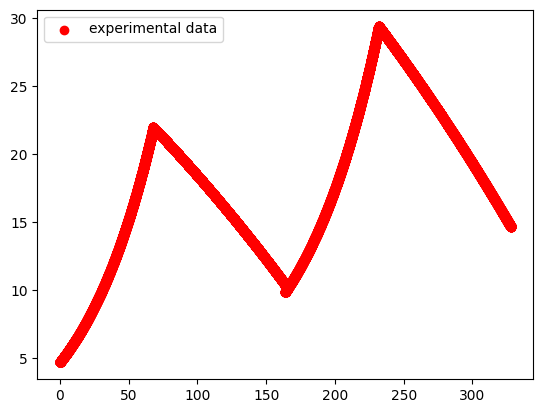

In [ ]:
plt.figure()
plt.scatter(list_time, list_Clac, label='experimental data', color='red')
plt.legend()
plt.show()